In [1]:
# Import Dependencies
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.models import Sequential, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K

Using plaidml.keras.backend backend.


In [2]:
def binary_model(img_dims, classes):
    # Initialize the model
    model = Sequential()
    input_shape = (img_dims[1], 
                   img_dims[0], 
                   img_dims[2])
    chan_dim = -1
    
    # Update input_shape if using channels_first
    if K.image_data_format() == "channels_first":
        input_shape = (img_dims[2], 
                       img_dims[1], 
                       img_dims[0])
        chan_dim = 1
    
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model
    

In [3]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from  scipy import ndimage
from keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

In [4]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 75
INIT_LR = 1e-3
BS = 32
IMG_DIMS = (28, 28, 3)

MODEL_NAME = "gender"

data_set_dir = 'data/dataset/' + MODEL_NAME


In [5]:
def split_train_test_set(directory):
    
    classifiers = next(os.walk(data_set_dir))[1]
    
    print("[INFO] loading images from {}".format(directory))
    # initialize the data and labels
    data = []
    labels = []
    
    # grab the image paths and randomly shuffle them
    image_paths = sorted(list(paths.list_images(directory)))
    random.seed(42)
    random.shuffle(image_paths)
    
    # loop over the input images
    for image_path in image_paths:
        # load the image, pre-process it, and store it in the data list
        image = cv2.imread(image_path)
        image = cv2.resize(image, (28, 28))
        image = img_to_array(image)
        data.append(image)
 
        # extract the class label from the image path and update the
        # labels list        
        label = image_path.split(os.path.sep)[-2]
        l = classifiers.index(label)
        labels.append(l)
        
    # scale the raw pixel intensities to the range [0, 1]
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
     
    # partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    train_X, test_X, train_Y, test_Y = train_test_split(data,
                                                        labels,
                                                        test_size=0.2,
                                                        random_state=42)
 
    # convert the labels from integers to vectors
    train_Y = to_categorical(train_Y, num_classes=2)
    test_Y = to_categorical(test_Y, num_classes=2)
    
    return train_X, test_X, train_Y, test_Y, classifiers
        

In [6]:
def show_model_performance_graph(model):
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    N = EPOCHS
    plt.plot(np.arange(0, N), 
             model.history["loss"], 
             label="train_loss")
    plt.plot(np.arange(0, N), 
             model.history["val_loss"], 
             label="val_loss")
    
    plt.plot(np.arange(0, N), 
             model.history["acc"], 
             label="train_acc")
    plt.plot(np.arange(0, N), 
             model.history["val_acc"], 
             label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

In [7]:
def train_model(dataset_dir):
    train_X, test_X, train_Y, test_Y, classifiers = split_train_test_set(dataset_dir)
    
    # initialize the model
    print("[INFO] compiling model...")
    model = binary_model(IMG_DIMS, classes=2)
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy",
                  optimizer=opt, 
                  metrics=["accuracy"])
    
    # construct the image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest")
    
    # train the network
    print("[INFO] training network...")
    h = model.fit_generator(
        aug.flow(train_X, train_Y, batch_size=BS),
        validation_data=(test_X, test_Y), 
        steps_per_epoch=len(train_X) // BS,
        epochs=EPOCHS, 
        verbose=1)
    # save the model to disk
    print("[INFO] serializing network...")
    model.save(MODEL_NAME + "_model.h5")
    return h, model, classifiers

In [8]:
h, model, classifiers = train_model(data_set_dir)

[INFO] loading images from data/dataset/gender
[INFO] compiling model...


INFO:plaidml:Opening device "metal_amd_radeon_r9_m370x.0"


[INFO] training network...
Epoch 1/75
30/30 [==============================] - 13s 419ms/step - loss: 0.7062 - acc: 0.5595 - val_loss: 0.6052 - val_acc: 0.5455
Epoch 2/75
30/30 [==============================] - 2s 79ms/step - loss: 0.5861 - acc: 0.6766 - val_loss: 0.5252 - val_acc: 0.7149
Epoch 3/75
30/30 [==============================] - 2s 78ms/step - loss: 0.5868 - acc: 0.6672 - val_loss: 0.5067 - val_acc: 0.6777
Epoch 4/75
30/30 [==============================] - 2s 76ms/step - loss: 0.5550 - acc: 0.6826 - val_loss: 0.5082 - val_acc: 0.7231
Epoch 5/75
30/30 [==============================] - 2s 77ms/step - loss: 0.5544 - acc: 0.7216 - val_loss: 0.7029 - val_acc: 0.5744
Epoch 6/75
30/30 [==============================] - 2s 76ms/step - loss: 0.5253 - acc: 0.7402 - val_loss: 0.5478 - val_acc: 0.6901
Epoch 7/75
30/30 [==============================] - 2s 78ms/step - loss: 0.5493 - acc: 0.7266 - val_loss: 0.5590 - val_acc: 0.6529
Epoch 8/75
30/30 [==============================] - 2s

Epoch 63/75
30/30 [==============================] - 4s 145ms/step - loss: 0.2614 - acc: 0.8828 - val_loss: 0.2510 - val_acc: 0.8843
Epoch 64/75
30/30 [==============================] - 2s 77ms/step - loss: 0.2877 - acc: 0.8916 - val_loss: 0.2180 - val_acc: 0.9132
Epoch 65/75
30/30 [==============================] - 2s 80ms/step - loss: 0.2578 - acc: 0.8979 - val_loss: 0.2207 - val_acc: 0.9091
Epoch 66/75
30/30 [==============================] - 2s 80ms/step - loss: 0.2613 - acc: 0.8905 - val_loss: 0.2371 - val_acc: 0.8926
Epoch 67/75
30/30 [==============================] - 2s 79ms/step - loss: 0.2450 - acc: 0.8947 - val_loss: 0.2484 - val_acc: 0.9091
Epoch 68/75
30/30 [==============================] - 2s 75ms/step - loss: 0.2474 - acc: 0.9050 - val_loss: 0.2419 - val_acc: 0.9050
Epoch 69/75
30/30 [==============================] - 2s 76ms/step - loss: 0.2588 - acc: 0.8945 - val_loss: 0.3014 - val_acc: 0.8802
Epoch 70/75
30/30 [==============================] - 2s 77ms/step - loss: 0

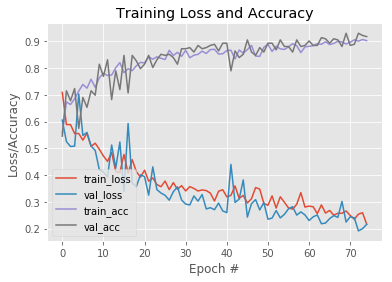

In [9]:
show_model_performance_graph(h)

### Test

In [10]:
# model = binary_model(IMG_DIMS, classes=2)
# model.load_weights("./gender_model.h5")

In [26]:
# load the image
image = cv2.imread('./test6.jpg')
orig = image.copy()

# pre-process the image for classification
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [27]:
prediction = model.predict(image)[0]

In [31]:
print(classifiers)
print(prediction)

['male', 'female']
[4.7540932e-04 9.9952459e-01]


In [28]:
for i, label in enumerate(classifiers):
    print("{}: {:.2}%".format(label, prediction[i]))

male: 0.00048%
female: 1.0%
